In [1]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((10.923157 34.607724, 10.923157 34.837984, 11.406555 34.837984, 11.406555 34.607724, 10.923157 34.607724))"
search_results, total_count = dag.search(
    productType="S1_SAR_GRD",
    geom=geometry,
    start="2023-10-26",
    end="2023-12-03",
    cloudCover=0,
)

In [2]:
import os
os.environ["EODAG__CREODIAS_S3__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.relpath('./Products/downloads')

In [3]:
import rasterio
import pprint

#print all the images available
pprint.pprint(search_results)

[EOProduct(id=S1A_IW_GRDH_1SDV_20231112T171226_20231112T171251_051187_062C9B_729C, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231113T051410_20231113T051435_051194_062CE0_0EA1, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231117T172033_20231117T172058_051260_062F14_2408, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231118T052222_20231118T052247_051267_062F56_D1E6, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231124T171226_20231124T171251_051362_0632A5_4A7D, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231125T051409_20231125T051434_051369_0632EA_8B33, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231129T172032_20231129T172057_051435_06351E_AD8B, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231130T052221_20231130T052246_051442_063550_C7C7, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231031T171227_20231031T171252_051012_062696_976A, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231101T051410

In [4]:
#donwload the disired image for us it is the 6th
product = search_results[3]
product_path = product.download()

0.00B [00:00, ?B/s]

In [5]:
product_path

'/tmp/S1A_IW_GRDH_1SDV_20231118T052222_20231118T052247_051267_062F56_D1E6'

In [6]:
import os
import glob


# Get a list of all files in the product_path directory
files_in_directory = os.listdir(product_path)

# Filter the list to include only files (not directories)
files = [file for file in files_in_directory if os.path.isfile(os.path.join(product_path, file))]

# Print the list of files
print("Files in the directory:", files)


Files in the directory: ['S1A_IW_GRDH_1SDV_20231118T052222_20231118T052247_051267_062F56_D1E6.SAFE-report-20231118T061834.pdf', 'manifest.safe']


In [7]:
import os
import glob

# Get a list of all files and subdirectories in the product_path directory
entries = os.listdir(product_path)

# Filter the list to include only subdirectories
subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(product_path, entry))]

# Print the list of subdirectories
print("Subdirectories in the directory:", subdirectories)

# Search for the preview image in subdirectories
preview_image_path = None
for subdirectory in subdirectories:
    preview_image_files = glob.glob(os.path.join(product_path, subdirectory, "*.png"))
    if preview_image_files:
        preview_image_path = preview_image_files[0]
        break

# Print the preview image path
if preview_image_path:
    print("Preview Image Path:", preview_image_path)
else:
    print("No preview image found.")


Subdirectories in the directory: ['support', 'annotation', 'measurement', 'preview']
Preview Image Path: /tmp/S1A_IW_GRDH_1SDV_20231118T052222_20231118T052247_051267_062F56_D1E6/preview/thumbnail.png


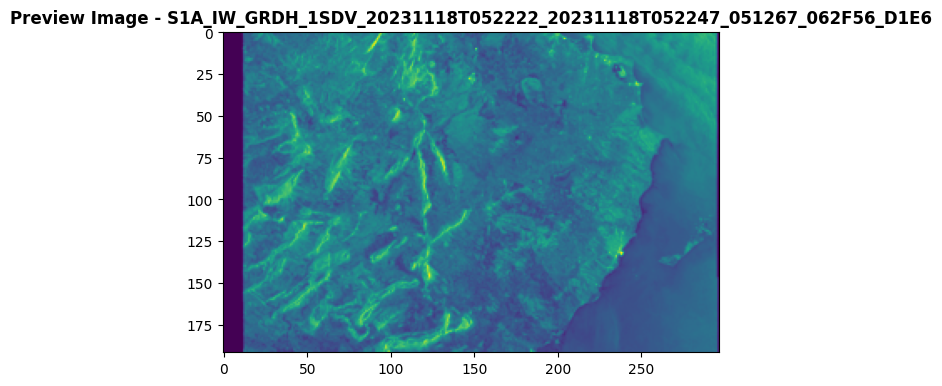

In [13]:
import glob
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already downloaded the product and set the product_path
# ...

# Stores the product name, as it will be used in the next lines to construct the path to the image to show
product_name = product.properties['title']

# Looks for the Preview Image, stores the path. The preview image is quicker to load and display
path = glob.glob(os.path.join(product_path, "preview", "*.png"))[0]

# Opens the image with rasterio, a python library
img = rasterio.open(path)

# Read the raster data (assuming it's a 2D array)
raster_data = img.read(1)

# Calculate the magnitude of the complex data
magnitude_data = np.abs(raster_data)

# Plots the preview image
magnitude_data=np.transpose(magnitude_data)
magnitude_data=np.rot90(magnitude_data,k=-1)
show(magnitude_data, title=f"Preview Image - {product_name}")

# Optionally, you can also use matplotlib to show the image
plt.show()


In [17]:
import re
product_name = product.properties['title'].replace('.SAFE','')

search_results, _ = dag.search(id=product_name)

In [18]:
import rasterio

# Looks for the Preview Image, stores the path. The preview image is quicker to load and display
path = glob.glob(os.path.join(product_path, "measurement", "*.tiff"))[0]  # Assuming the preview image is in PNG format within the 'preview' subdirectory

# Opens the image with rasterio, a python library
with rasterio.open(path) as src:
    # Get the names of the bands
    band_names = [f"Band {index}" for index in src.indexes]

    # Print the band names
    print("Band Names:", band_names)


Band Names: ['Band 1']


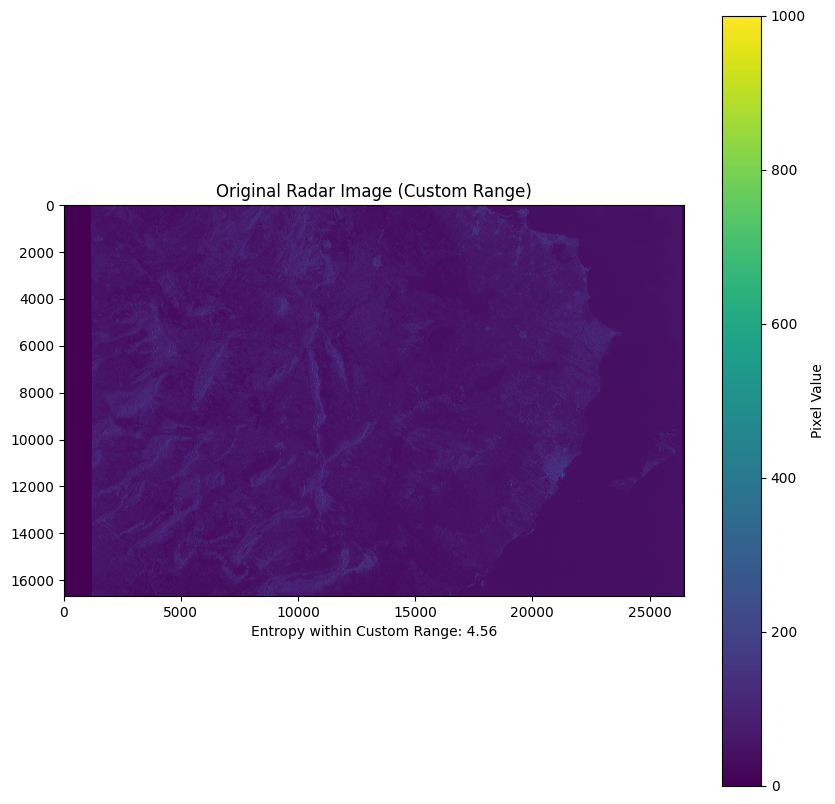

Entropy of the image within Custom Range: 4.5622985830115


In [20]:
import os
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Replace 'your_image_path' with the actual path to your radar image
path = glob.glob(os.path.join(product_path, "measurement", "*.tiff"))[0]

# Function to calculate entropy within a specified range
def calculate_entropy_within_range(image_data, value_range):
    mask = (image_data >= value_range[0]) & (image_data <= value_range[1])
    flat_image = image_data[mask].flatten()
    hist, _ = np.histogram(flat_image, bins=256, range=(value_range[0], value_range[1]))
    probabilities = hist / hist.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy

# Set your custom range for visualization
custom_range = (0, 1000)

# Calculate entropy for the single-band image within the custom range
with rasterio.open(path) as src:
    band_data = src.read(1)
    entropy_band = calculate_entropy_within_range(band_data, custom_range)
band_data=np.transpose(band_data)
band_data=np.rot90(band_data,k=-1)

# Display the original radar image within the custom range
plt.figure(figsize=(10, 10))
plt.imshow(band_data, cmap='viridis', vmin=custom_range[0], vmax=custom_range[1])
plt.title('Original Radar Image (Custom Range)')
plt.colorbar(label='Pixel Value')
plt.xlabel('Entropy within Custom Range: {:.2f}'.format(entropy_band))
plt.show()


# Print the calculated entropy within the custom range
print(f'Entropy of the image within Custom Range: {entropy_band}')


In [1]:
import rasterio
import numpy as np

import matplotlib.pyplot as plt
import glob
import os

product_path='/tmp/S1A_IW_GRDH_1SDV_20231031T171252_20231031T171317_051012_062696_BBDD'
# Replace 'your_vh_path' and 'your_vv_path' with the actual paths to your VH and VV band images
vh_path = glob.glob(os.path.join(product_path, "measurement", "*.tiff"))[0]
vv_path = glob.glob(os.path.join(product_path, "measurement", "*.tiff"))[1]

# Open the VH and VV band images with rasterio
with rasterio.open(vh_path) as vh_src, rasterio.open(vv_path) as vv_src:
    # Read the data for the VH and VV bands
    vh_data = vh_src.read(1)
    vv_data = vv_src.read(1)
# Display the results

# vh_data = vh_data/vh_data.max()
# vv_data = vv_data/vv_data.max()

# plt.figure(figsize=(12, 6))

# plt.subplot(1, 3, 1)
# plt.imshow(vh_data, cmap='viridis', vmin=vh_data.min(), vmax=vh_data.max())
# plt.title('VH Band')

# plt.subplot(1, 3, 2)
# plt.imshow(vv_data, cmap='viridis', vmin=vv_data.min(), vmax=vv_data.max())
# plt.title('VV Band')


In [24]:
vh_data.min()

0.0

In [2]:
vh_data = vh_data/vh_data.max()
vh_data=vh_data
vv_data = vv_data/vv_data.max()
vv_data=vv_data
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 3, 1)
# plt.imshow(vh_data, cmap='viridis', vmin=vh_data.min(), vmax=vh_data.max())
# plt.title('VH Band')

# plt.subplot(1, 3, 2)
# plt.imshow(vv_data, cmap='viridis', vmin=vv_data.min(), vmax=vv_data.max())
# plt.title('VV Band')

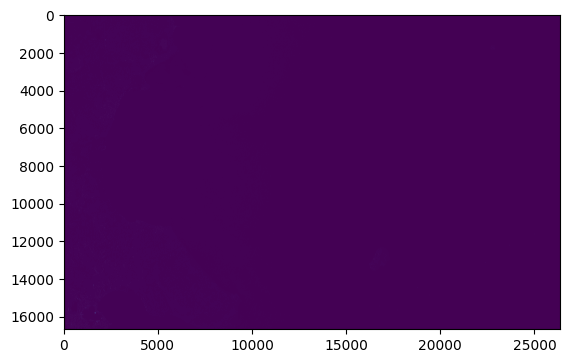

In [3]:
plt.imshow(vv_data, cmap='viridis', vmin=0, vmax=0.8)



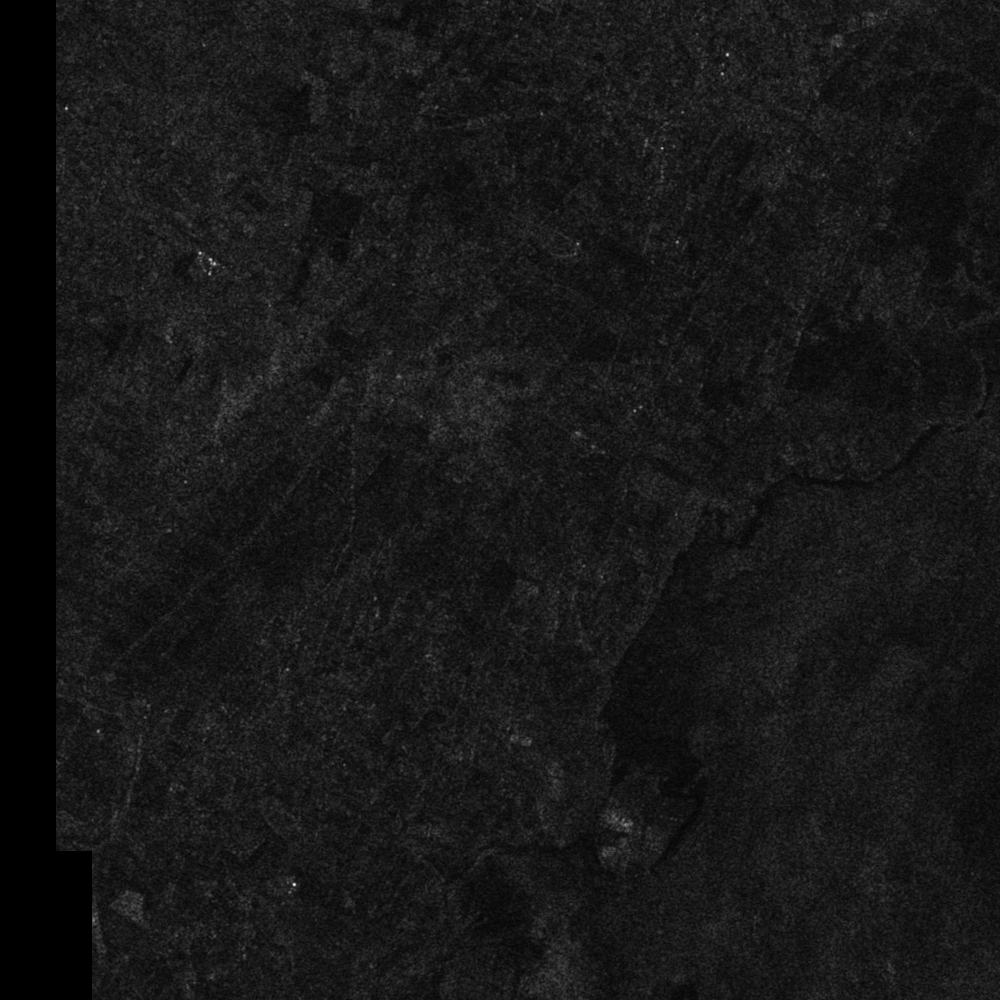

In [15]:
# import panel as pn
import folium
import numpy as np

# Create a Folium map centered at a specific location (for example, [latitude, longitude])
m = folium.Map(location=[36.662801, 10.861985], zoom_start=10)
overlay = folium.raster_layers.ImageOverlay(

    image=vv_data,  # Pass the values of your xarray variable
    bounds=[[36.662801, 10.861985], [36.913557, 11.388624 ]],  # Define the bounds
    opacity=0.7,
    name='Your Data Overlay',
).add_to(m)
m

In [16]:
vh_data.min()

0.0

In [17]:
type(vh_data)

numpy.ndarray